In [1]:
import cv2
import torch 

from table_reconstruction.line_segmentation.line_segment import LineSegmentation
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

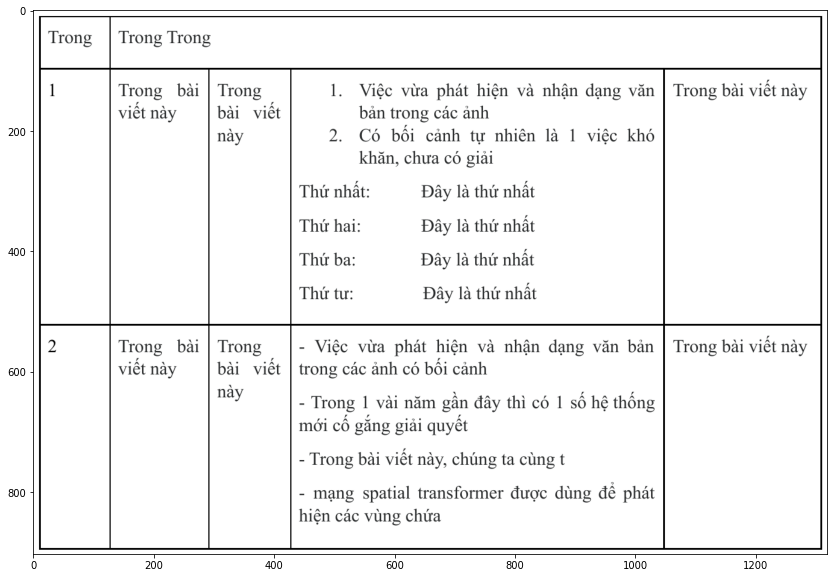

In [3]:
img_path = "table.png"
img = cv2.imread(img_path)
plt.imshow(img)

Downloading...
From: https://drive.google.com/u/0/uc?id=18YEiAzUs9NXz0FwBuU0JicEWc_F2V7tq
To: /home/hps02/SUN/table_reconstruction/venv/lib/python3.8/site-packages/table_reconstruction-0.1.dev15+gfec7ad1.d20210915-py3.8.egg/table_reconstruction/line_segmentation/tmp/resnet_weight.pth
25.7MB [00:12, 2.07MB/s]


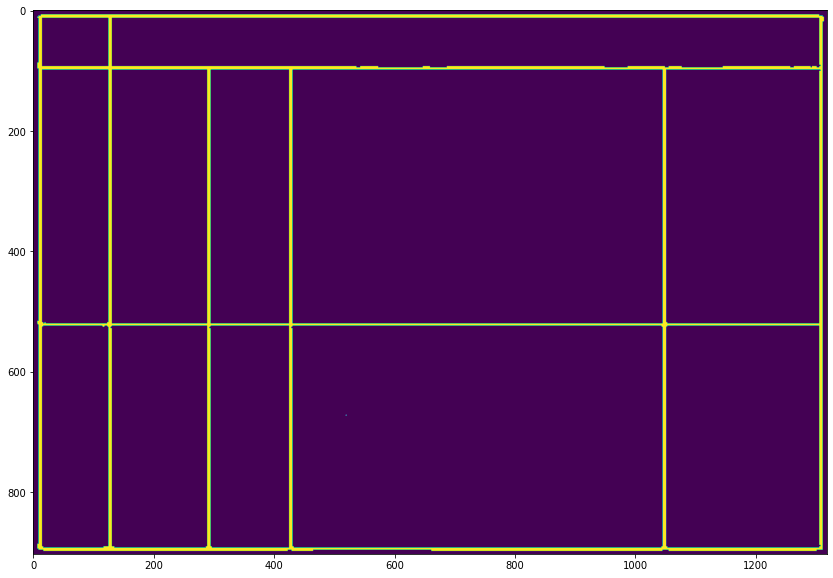

In [4]:
line_segmentation = LineSegmentation(device=device)
mask = line_segmentation.predict(img)
plt.imshow(mask)

In [8]:
img.shape[0:2] == mask.shape[0:2]

True